In [19]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
from IPython.display import display
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

Initializing files

In [20]:
CO2toWh = 0.3712
EmissionsPerCarGas = pd.read_csv('data/vehicle_co2_emissions.csv')
EmissionsPerCarGas = EmissionsPerCarGas.iloc[:, [0, 1, -1]]
df_electric_car = pd.read_csv('data/us_electric_car_data.csv')

ElectricCarsWh = pd.read_csv('data/ev_energy_consumption.csv')
ElectricCars = ElectricCarsWh[['Make', 'Model']]
ElectricCars['CO2 Emissions(g/km)'] = ElectricCarsWh['WhKm'] * CO2toWh

EmissionsPerCar = pd.concat([EmissionsPerCarGas, ElectricCars], ignore_index=True)


Usage Data.
Our goal here is to create an estimate of the equivalent CO2 emmited by Electric Cars, and then add that data to the data we have for other vehicle types.  This can be done fairly easily by using the stats of how many WattHours(wH) a specific electric car uses per kilometer, and multiply by well broadcasted data of how many Kg CO2 is emmited by producing one KwH of energy in the US

In [21]:
import csv

CarRating = EmissionsPerCar[['Make', 'Model']].copy()
CarRating['Rating'] = 10 - (EmissionsPerCar['CO2 Emissions(g/km)'] / 52.2)

max_rating = CarRating.loc[CarRating['Rating'].idxmax()]
min_rating = CarRating.loc[CarRating['Rating'].idxmin()]
average_rating = CarRating['Rating'].mean()

print(f"The car with the best rating is a {max_rating['Make']} {max_rating['Model']} with a rating of {max_rating['Rating']}")
print(f"The car with the worst rating is {min_rating['Make']} {min_rating['Model']} with a rating of {min_rating['Rating']}")
print(f"The average rating of the {CarRating.shape[0]} car models is {average_rating}")

display(CarRating)
display(EmissionsPerCar)

# Writing results to output CSV file
CarRating.to_csv("data/final_ratings.csv", sep=",", index=False)



The car with the best rating is a Tesla Model 3 with a rating of 9.025777777777778
The car with the worst rating is BUGATTI CHIRON with a rating of 0.0
The average rating of the 7749 car models is 5.359881729888271


,Make,Model,Rating
0,ACURA,ILX,6.245211
1,ACURA,ILX,5.766284
2,ACURA,ILX HYBRID,7.394636
3,ACURA,MDX 4WD,5.114943
4,ACURA,RDX AWD,5.325670
...,...,...,...
7744,Mercedes,EQV 300 Extra-Long,7.937778
7745,Mercedes,eVito Tourer Long 90 kWh,7.937778
7746,Mercedes,EQV 300 Long,7.937778
7747,Mercedes,eVito Tourer Extra-Long 60 kWh,7.916444


,Make,Model,CO2 Emissions(g/km)
0,ACURA,ILX,196.0000
1,ACURA,ILX,221.0000
2,ACURA,ILX HYBRID,136.0000
3,ACURA,MDX 4WD,255.0000
4,ACURA,RDX AWD,244.0000
...,...,...,...
7744,Mercedes,EQV 300 Extra-Long,107.6480
7745,Mercedes,eVito Tourer Long 90 kWh,107.6480
7746,Mercedes,EQV 300 Long,107.6480
7747,Mercedes,eVito Tourer Extra-Long 60 kWh,108.7616


Manufacturing
-Lithium Ion Production
Initializing a Dataframe with General Emissions for Lithium Ion Battery of kWh size All of the data is in kg. I will then plot the values of manufacturing the Batteries to find their best-fit Equations. These equations can then be used to find the amount of carbon emmited for batteries of any size.  

Low Range (Kg CO2): y = -0.0000x^2 + 40.0000x + -0.0000
Medium Range (Kg CO2): y = 0.1014x^2 + 129.6242x + 210.4748
High Range (Kg CO2): y = -0.0000x^2 + 200.0000x + -0.0000


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


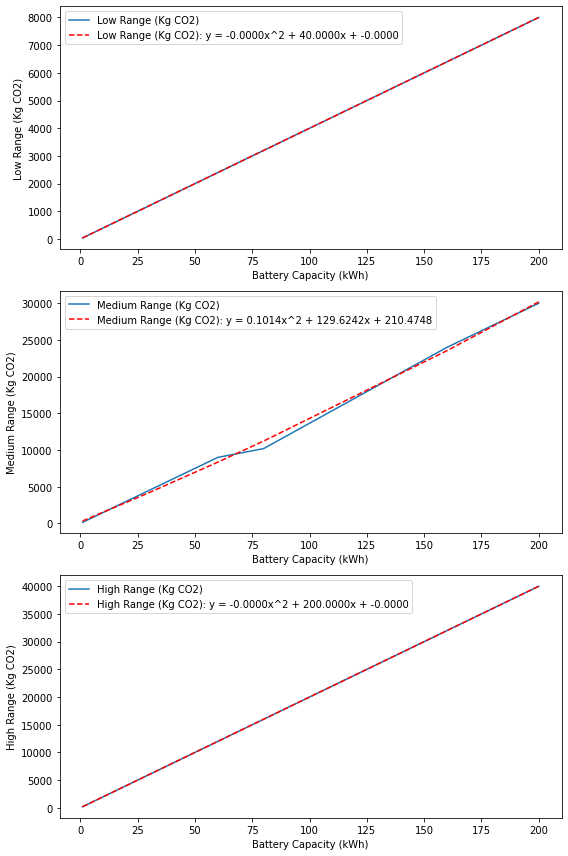

In [22]:
LithiumCO2 = pd.read_csv('data/lithium_battery_manufacturing.csv')

def quadratic_func(x, a, b, c):
    return a * x**2 + b * x + c

x_values = LithiumCO2['Battery Capacity (kWh)']
y_ranges = ['Low Range (Kg CO2)', 'Medium Range (Kg CO2)', 'High Range (Kg CO2)']

fig, axes = plt.subplots(3, 1, figsize=(8, 12))
best_fit_parameters = []

for i, y_range in enumerate(y_ranges):
    params, covariance = curve_fit(quadratic_func, x_values, LithiumCO2[y_range])
    best_fit_parameters.append(params)
    equation = f'{y_range}: y = {params[0]:.4f}x^2 + {params[1]:.4f}x + {params[2]:.4f}'
    axes[i].plot(x_values, LithiumCO2[y_range], label=y_range)
    axes[i].plot(x_values, quadratic_func(x_values, *params), 'r--', label=equation)
    axes[i].set_xlabel('Battery Capacity (kWh)')
    axes[i].set_ylabel(y_range)
    axes[i].legend()
    print(equation)

plt.tight_layout()
plt.show()



Now we need to estimate the manufacturing output for building lithium Ion Batteries. This can be used for the manufacturing data for electric vehicles

In [23]:
electric_car = df_electric_car[df_electric_car['Electric Range'] > 0]
df_lithium_production = pd.DataFrame(columns=['Make', 'Model', 'CO2 Emission (kg CO2)'])
df_lithium_production[['Make', 'Model']] = electric_car[['Make', 'Model']]
df_lithium_production['CO2 Emission (kg CO2)'] = electric_car['Electric Range'] * 200
df_lithium_production = df_lithium_production.drop_duplicates(subset='Model', keep='first', inplace=False, ignore_index=False)
display(df_lithium_production)


,Make,Model,CO2 Emission (kg CO2)
0,TESLA,MODEL 3,44000
4,TESLA,MODEL S,41600
5,BMW,I3,19400
7,AUDI,Q5 E,3600
8,TOYOTA,PRIUS PRIME,5000
...,...,...,...
42221,AZURE DYNAMICS,TRANSIT CONNECT ELECTRIC,11200
57427,PORSCHE,918,2400
60778,BENTLEY,BENTAYGA,3600
81093,AUDI,A8 E,3400


Now we will estimate the manufacturing of other vehicles, by using the size of the vehicle to decide their CO2 emissions 

In [24]:
ClassTypes = [['TWO-SEATER', 5600], ['MINICOMPACT', 5600], ['SUBCOMPACT', 5600], ['COMPACT', 5600], ['MID-SIZE', 5600], ['FULL-SIZE', 5600], ['SUV - SMALL', 5600], ['SUV - STANDARD', 5600], ['PICKUP TRUCK - SMALL', 5600], ['PICKUP TRUCK - STANDARD', 5600], ['STATION WAGON - SMALL', 5600], ['STATION WAGON - MID-SIZE', 5600],['MINIVAN', 5600], ['VAN - CARGO', 5600], ['VAN - PASSENGER', 5600], ['SPECIAL PURPOSE VEHICLE', 5600]]
df_manufacturing = pd.read_csv('data/vehicle_co2_emissions.csv')
df_manufacturing = df_manufacturing.iloc[:, [0, 1, 2, 3]]
df_classtypes = df_manufacturing.drop_duplicates(subset='Vehicle Class')
manufacturing_estimate = df_manufacturing['Engine Size(L)'] * 200 
class_type_dict = {item[0]: item[1] for item in ClassTypes}
df_manufacturing['kg CO2'] = df_manufacturing['Vehicle Class'].map(class_type_dict)
df_manufacturing['kg CO2'] = df_manufacturing['kg CO2'] + manufacturing_estimate

display(df_manufacturing)

,Make,Model,Vehicle Class,Engine Size(L),kg CO2
0,ACURA,ILX,COMPACT,2.0,6000.0
1,ACURA,ILX,COMPACT,2.4,6080.0
2,ACURA,ILX HYBRID,COMPACT,1.5,5900.0
3,ACURA,MDX 4WD,SUV - SMALL,3.5,6300.0
4,ACURA,RDX AWD,SUV - SMALL,3.5,6300.0
...,...,...,...,...,...
7380,VOLVO,XC40 T5 AWD,SUV - SMALL,2.0,6000.0
7381,VOLVO,XC60 T5 AWD,SUV - SMALL,2.0,6000.0
7382,VOLVO,XC60 T6 AWD,SUV - SMALL,2.0,6000.0
7383,VOLVO,XC90 T5 AWD,SUV - STANDARD,2.0,6000.0
